In [13]:
import cv2
import imutils
import numpy as np
from sklearn.metrics import pairwise

import os
import warnings
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [14]:
# global variable
bg = None

In [15]:
# ---------------------------------------------
# To segment the region of hand in the image
# ---------------------------------------------
def segment(image, grayimage, threshold=100):
    # threshold the image to get the foreground which is the hand
    thresholded = cv2.threshold(grayimage, threshold, 255, cv2.THRESH_BINARY)[1]
    
    # lower_color = np.array([0, 10, 60], dtype=np.uint8)
    # upper_color = np.array([20, 150, 255], dtype=np.uint8)
    # mask = cv2.inRange(grayimage, lower_color, upper_color)
    # mask = cv2.medianBlur(mask, 5)
    # thresholded = cv2.threshold(255-mask, threshold, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)

        return (thresholded, segmented)


In [16]:
# --------------------------------------------------------------
# To count the number of fingers in the segmented hand region
# --------------------------------------------------------------
def count(image, thresholded, segmented):
    # find the convex hull of the segmented hand region
    # which is the maximum contour with respect to area
    chull = cv2.convexHull(segmented)

    # find the most extreme points in the convex hull
    extreme_top = tuple(chull[chull[:, :, 1].argmin()][0])
    extreme_bottom = tuple(chull[chull[:, :, 1].argmax()][0])
    extreme_left = tuple(chull[chull[:, :, 0].argmin()][0])
    extreme_right = tuple(chull[chull[:, :, 0].argmax()][0])

    # find the center of the palm
    cX = int((extreme_left[0] + extreme_right[0]) / 2)
    cY = int((extreme_top[1] + extreme_bottom[1]) / 2)

    # find the maximum euclidean distance between the center of the palm
    # and the most extreme points of the convex hull
    distances = pairwise.euclidean_distances([(cX, cY)], Y=[extreme_left, extreme_right, extreme_top, extreme_bottom])[
        0]
    max_distance = distances[distances.argmax()]

    # calculate the radius of the circle with 80% of the max euclidean distance obtained
    radius = int(0.8 * max_distance)

    # find the circumference of the circle
    circumference = (2 * np.pi * radius)

    # initialize circular_roi with same shape as thresholded image
    circular_roi = np.zeros(thresholded.shape[:2], dtype="uint8")

    # draw the circular ROI with radius and center point of convex hull calculated above
    cv2.circle(circular_roi, (cX, cY), radius, 255, 1)

    # take bit-wise AND between thresholded hand using the circular ROI as the mask
    # which gives the cuts obtained using mask on the thresholded hand image
    circular_roi = cv2.bitwise_and(thresholded, thresholded, mask=circular_roi)

    # compute the contours in the circular ROI
    (cnts, _) = cv2.findContours(circular_roi.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    count = 0
    # approach 1 - eliminating wrist
    # cntsSorted = sorted(cnts, key=lambda x: cv2.contourArea(x))
    # print(len(cntsSorted[1:])) # gives the count of fingers

    # approach 2 - eliminating wrist
    # loop through the contours found
    for i, c in enumerate(cnts):

        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)

        # increment the count of fingers only if -
        # 1. The contour region is not the wrist (bottom area)
        # 2. The number of points along the contour does not exceed
        #     25% of the circumference of the circular ROI
        if ((cY + (cY * 0.25)) > (y + h)) and ((circumference * 0.25) > c.shape[0]):
            count += 1

    return count

In [17]:
frame = cv2.imread('test/peace.png')
frame = imutils.resize(frame, width=500)
clone = frame.copy()
(height, width) = frame.shape[:2]

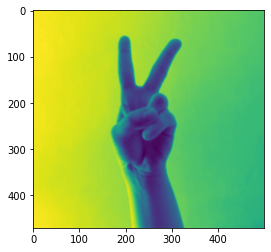

In [18]:
# convert the frame to grayscale and blur it
grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
grey = cv2.GaussianBlur(grey, (7, 7), 0)
plt.imshow(grey)

2


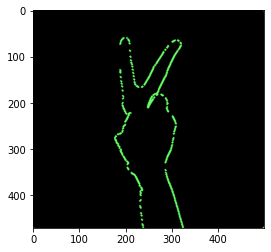

In [19]:
# segment the hand region
hand = segment(clone, grey)

if hand is not None:
    # if yes, unpack the thresholded image and segmented contour
    (thresholded, segmented) = hand

    # show countours
    canvas = np.zeros_like(clone)
    cv2.drawContours(canvas , segmented, -1, (100, 255, 100), 3)

    plt.imshow(canvas)

    # count the number of fingers
    fingers = count(clone, thresholded, segmented)
    print(fingers)

    cv2.putText(clone, "This is " + str(fingers), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)